# Light example: generate influence diagram


In [141]:
# imports
import os
import matplotlib.pyplot as plt
from pylab import *
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

from IPython.display import display,HTML
import re

# structures

based on TNO report: Guided root analysis of machine failure, par 5.2

component structure
per component
- define inputs and outputs
- define failure modes
- relation between inputs and outputs for normal behavior and for every failure mode

assembly structure
- components that are part of the assembly
- how the components are connected

specification
- inputs and outputs are associated with modalities and modality has properties


prerequisites:
- every component has one health and one output variable. multiple inputs are possible


In [138]:
# component Switch > Python datastructure dictionary

switch = {
    "name":"Switch",
    "Inputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"]
        },
        "2":
        {
            "modality":"State",
            "property":"Enabled",
            "propertyvalues":["yes", "no"]
        }
    },
    "Outputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"]
        }
    },
    "Healths":{
        "1":{
            "modality":"Health",
            "property":"health",
            "propertyvalues":["ok","broken"]
        }
    }

}

In [158]:
# component Light > Python datastructure dictionary

light = {
    "name":"Light",
    "Inputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"]
        }
    },
    "Outputs":{
        "1":{
            "modality":"Light",
            "property":"Present",
            "propertyvalues":["yes", "no"]
        }
    },
    "Healths":{
        "1":{
            "modality":"Health",
            "property":"health",
            "propertyvalues":["ok","broken"]
        }
    }
}

In [163]:
def addComponentToDiagram(diag, comp):
    componentkeys = ["Inputs","Outputs","Healths"]
    keys = comp.keys()
    labels = []
    if "name" in keys:
        name = comp['name']
        print("name component: " + name)
        
    # read inputs, outputs and health, add named variable to diagram 
    for ckey in componentkeys:
        if ckey in keys:  
            for modality in comp[ckey].keys():                                             # get modalities
                modalitylabel = comp[ckey][modality]["modality"]                           # get modality label
                property = comp[ckey][modality]["property"]                                # get property label
                propertyvalues = comp[ckey][modality]["propertyvalues"]                    # get property values
                if(ckey == "Healths"):                                                     # shorter name for health
                    label = str(property + name)
                else:
                    label = str(property + modalitylabel + ckey + name)                    # name variable
                labels.append(label)
                diag.addChanceNode(gum.LabelizedVariable(label, label, propertyvalues))    # add variable to diagram

  
    inputvars = []
    for label in labels:
        if(re.search("Inputs", label)):
            inputvars.append(diag.idFromName(label))
        if(re.search("health", label)):
            hvar = diag.idFromName(label)
        if(re.search("Outputs",label)):
            ovar = diag.idFromName(label)
    # add arc for health to output
    diag.addArc(hvar, ovar)
    # add arc for every input to output
    for v in inputvars:
        diag.addArc(v,ovar)        
    

In [170]:
def addConnectionToDiagram(diag, connection):
    name = connection['name']
    startvar = diag.idFromName(connection['start'])
    endvar = diag.idFromName(connection['end'])
    diag.addArc(startvar, endvar)
    label = str("health" + name)
    diag.addChanceNode(gum.LabelizedVariable(label,label,["ok","broken"]))

connections connect components to each other
- connections have a name
- connections have two named components and a direction
- connections have a health that is connected to the component that is addressed by the connection

In [167]:
wire = {
    "name":"Wire",
    "start":"PresentPowerOutputsSwitch",
    "end":"PresentPowerInputsLight"    
}

In [ ]:
system = {
    "components":["light"]
}

name component: Switch
name component: Light
Influence Diagram{
  chance: 8,
  utility: 0,
  decision: 0,
  arcs: 6,
  domainSize: 256
}


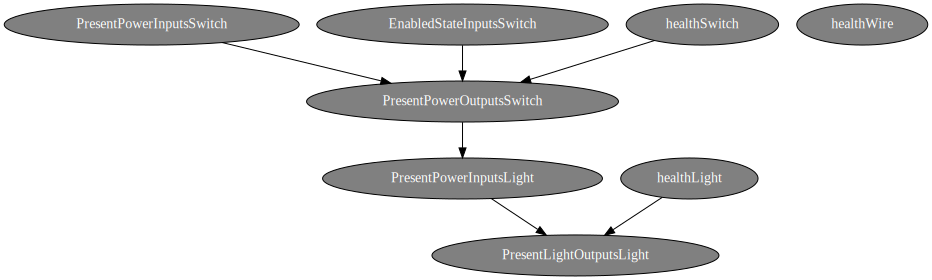

In [171]:
# create influence diagram and add components
diagram = gum.InfluenceDiagram()
addComponentToDiagram(diagram, switch)
addComponentToDiagram(diagram, light)
addConnectionToDiagram(diagram, wire)
print(diagram)
gnb.showInfluenceDiagram(diagram, size=60)

In [25]:
def addSwitch(diag):
    presentPowerInSwitch       = diag.addChanceNode(gum.LabelizedVariable('presentPowerInSwitch', 'presentPowerInSwitch', ['on','off']))
    presentEnableInSwitch      = diag.addChanceNode(gum.LabelizedVariable('presentEnableInSwitch', 'presentEnableInSwitch', ['on','off']))
    presentPowerOutputSwitch   = diag.addChanceNode(gum.LabelizedVariable('presentPowerOutputSwitch', 'presentPowerOutputSwitch', ['on','off']))

    healthSwitch               = diag.addChanceNode(gum.LabelizedVariable('healthSwitch', 'healthSwitch', ['ok','broken']))
    
    diag.addArc(presentPowerInSwitch , presentPowerOutputSwitch)
    diag.addArc(presentEnableInSwitch, presentPowerOutputSwitch)
    diag.addArc(healthSwitch         , presentPowerOutputSwitch)
    
    
def addLight(diag):
    presentPowerInLight        = diag.addChanceNode(gum.LabelizedVariable('presentPowerInLight', 'presentPowerInLight', ['on','off']))
    presentLightOutputLight    = diag.addChanceNode(gum.LabelizedVariable('present light output light', 'light', ['on','off']))

    healthWire   = diag.addChanceNode(gum.LabelizedVariable('healthWire', 'healthWire', ['ok','broken']))
    healthLight  = diag.addChanceNode(gum.LabelizedVariable('healthLight', 'healthLight', ['ok','broken']))
    
    diag.addArc(healthWire, presentPowerInLight)

    diag.addArc(presentPowerInLight, presentLightOutputLight)
    diag.addArc(healthLight, presentLightOutputLight)


- power > switch > draad > lamp
- present.power (yes/no)
- present.power.output.switch (yes/no)
- present.power.wire (yes/no)
- present.light.output.light (yes/no)

- health.switch
- health.wire
- health.light

Influence Diagram{
  chance: 8,
  utility: 0,
  decision: 0,
  arcs: 7,
  domainSize: 256
}


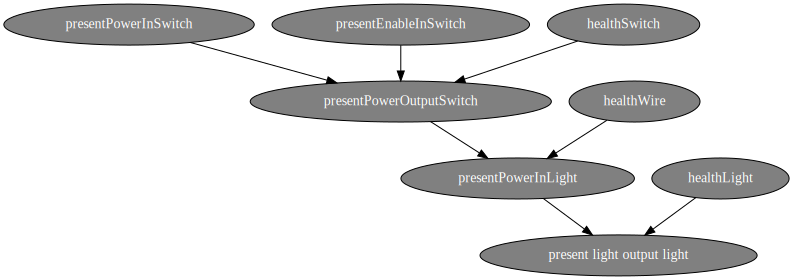

In [26]:
# create influence diagram
diagram = gum.InfluenceDiagram()
addSwitch(diagram)
addLight(diagram)

if("presentPowerOutputSwitch" in diagram.names()):
    out = diagram.idFromName("presentPowerOutputSwitch")
    inv = diagram.idFromName("presentPowerInLight")
    diagram.addArc(out, inv)

print(diagram)
gnb.showInfluenceDiagram(diagram, size=60)

In [19]:
diagram.names()

{'healthLight',
 'healthSwitch',
 'healthWire',
 'present light output light',
 'presentEnableInSwitch',
 'presentPowerInLight',
 'presentPowerInSwitch',
 'presentPowerOutputSwitch'}

# influence diagram structure; testcategories

Observations:
- observeLight    > observeer status lamp, resultaat is evidence mbt component lamp
- observeSwitch   > observeer status switch, resultaat is evidence mbt component switch
- checkLight      > check of de lamp kapot is, test mbt health lamp

change input
- flipSwitch > andere input voor lamp

Intervene state
- bypass switch]
- verdubbel de nodes behalve de health en input nodes, duplicaten worden kinderen van de originele health node

replace component
- vervang lamp > volg artikel
- verdubbel de nodes inclusief de health

In [51]:
# Observations

# requires base structure already present in diagram
# to model observation of a component a decision + utility is needed
# observeLight checks if lamp is on or off, evidence is set in presentLightOutputLight
# observeSwitch checks if switch is on or off, evidence is set in presentPowerOutputSwitch
# checklight checks if light is broken, evidence needs additional chance variable

#observe light
def addObservationObserveLight(diag):
    d_observeLight = diag.addDecisionNode(gum.LabelizedVariable('decision to observe light', 'observe light', ["yes", "no"]))
    u_observeLight = diag.addUtilityNode(gum.LabelizedVariable("utility observe light", "R(d_observeLight)", 1))
    diag.addArc(d_observeLight, presentLightOutputLight)
    diag.addArc(d_observeLight, u_observeLight)

#observe switch
def addObservationObserveSwitch(diag):
    d_observeSwitch = diag.addDecisionNode(gum.LabelizedVariable('decision to observe switch', 'observe switch', ["yes", "no"]))
    u_observeSwitch = diag.addUtilityNode(gum.LabelizedVariable("utility observe switch", "R(d_observeSwitch)", 1))
    diag.addArc(d_observeSwitch, presentPowerOutputSwitch)
    diag.addArc(d_observeSwitch, u_observeSwitch)

#checklight
def addObservationCheckLight(diag):
    t_checkLight = diag.addChanceNode(gum.LabelizedVariable('check light', 'check light', ["ok", "broken"]))
    d_checkLight = diag.addDecisionNode(gum.LabelizedVariable('decision to check light', 'check light', ["yes", "no"]))
    u_checkLight = diag.addUtilityNode(gum.LabelizedVariable("utility check light" , "R(d_checklight, health light)", 1))
    diag.addArc(d_checkLight, t_checkLight)
    diag.addArc(d_checkLight, u_checkLight)
    diag.addArc(healthLight, t_checkLight)
    

Influence Diagram{
  chance: 8,
  utility: 3,
  decision: 3,
  arcs: 13,
  domainSize: 2048
}


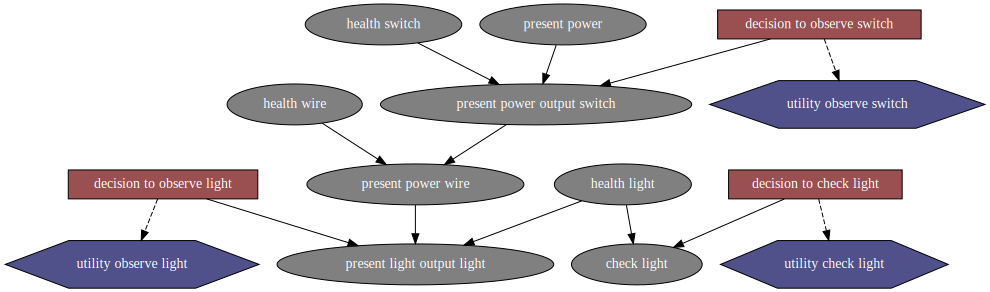

In [77]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# create influence diagram including observations
diagram = gum.InfluenceDiagram()
baseStructure(diagram)
baseArcs(diagram)
addObservationObserveLight(diagram)
addObservationObserveSwitch(diagram)
addObservationCheckLight(diagram)
print(diagram)
gnb.showInfluenceDiagram(diagram, size=60)

In [62]:
# change input > flip switch

#Augmentation procedure has two steps. 
# 1, duplicate all the nodes in the BN except for the health nodes and the input nodes not set to different values
# which are not set to a different value. 
# 2, connect the duplicated nodes as children of the original health nodes. 

def addFlipSwitch(diag):
    d_flipSwitch = diag.addDecisionNode(gum.LabelizedVariable('decision flip switch', 'flip switch', ["yes", "no"]))
    u_flipSwitch = diag.addUtilityNode(gum.LabelizedVariable("utility flip switch", "R(d_flipswitch)", 1))
    diag.addArc(d_flipSwitch, u_flipSwitch)
    diag.addArc(d_flipSwitch, presentPowerOutputSwitch)
    

def augmentFlipSwitch(diag):
    presentPowerOutputSwitch1   = diag.addChanceNode(gum.LabelizedVariable('present power output switch1', 'switch', ['on','off']))
    presentPowerWire1           = diag.addChanceNode(gum.LabelizedVariable('present power wire1', 'wire', ['on','off']))
    presentLightOutputLight1    = diag.addChanceNode(gum.LabelizedVariable('present light output light1', 'light', ['on','off']))

    diag.addArc(healthSwitch, presentPowerOutputSwitch1)

    diag.addArc(presentPowerOutputSwitch1, presentPowerWire1)
    diag.addArc(healthWire, presentPowerWire1)

    diag.addArc(presentPowerWire1, presentLightOutputLight1)
    diag.addArc(healthLight, presentLightOutputLight1)
   

Influence Diagram{
  chance: 7,
  utility: 1,
  decision: 1,
  arcs: 8,
  domainSize: 256
}


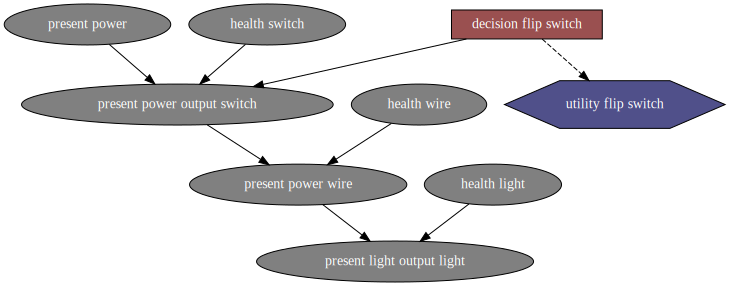

In [63]:
# create influence diagram including flip switch
diagram = gum.InfluenceDiagram()
baseStructure(diagram)
baseArcs(diagram)
#addObservationObserveLight(diagram)
#addObservationObserveSwitch(diagram)
#addObservationCheckLight(diagram)
addFlipSwitch(diagram) 
print(diagram)
gnb.showInfluenceDiagram(diagram, size=60)

Influence Diagram{
  chance: 10,
  utility: 1,
  decision: 1,
  arcs: 13,
  domainSize: 2048
}


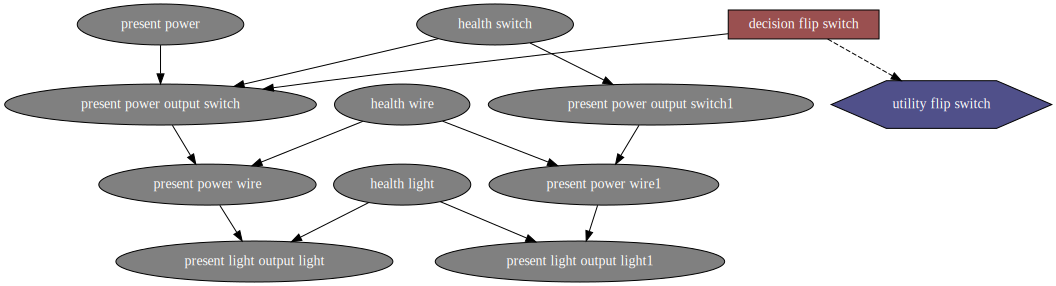

In [64]:
# create influence diagram including flip switch augmented
diagram = gum.InfluenceDiagram()
baseStructure(diagram)
baseArcs(diagram)
#addObservationObserveLight(diagram)
#addObservationObserveSwitch(diagram)
#addObservationCheckLight(diagram)
addFlipSwitch(diagram) 
augmentFlipSwitch(diagram)
print(diagram)
gnb.showInfluenceDiagram(diagram, size=60)

In [71]:
# replace part > new light

#Augmentation procedure has two steps. 
# 1, duplicate all the nodes in the BN except for the input nodes not set to different values
# not set to a different value. 
# 2, connect the duplicated nodes as children of the original health nodes except for the replaced part
# 3, connect new part to new health
def addReplaceLight(diag):
    d_replaceLight = diag.addDecisionNode(gum.LabelizedVariable('decision replace light', 'replace light', ["yes", "no"]))
    u_replaceLight = diag.addUtilityNode(gum.LabelizedVariable("utility replace light", "R(d_replace light)", 1))
    diag.addArc(d_replaceLight, u_replaceLight)
    diag.addArc(d_replaceLight, presentLightOutputLight)
    

def augmentReplaceLight(diag):
    presentLightOutputLight2    = diag.addChanceNode(gum.LabelizedVariable('present light output light2', 'light', ['on','off']))
    healthLight2  = diag.addChanceNode(gum.LabelizedVariable('health light2', 'health light', ['ok','broken']))
    
    diag.addArc(presentPowerWire, presentLightOutputLight2)
    diag.addArc(healthLight2, presentLightOutputLight2)

Influence Diagram{
  chance: 7,
  utility: 1,
  decision: 1,
  arcs: 8,
  domainSize: 256
}


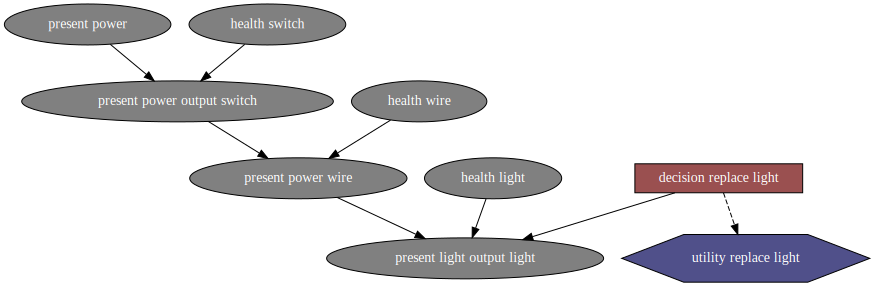

In [72]:
# create influence diagram, replace light
diagram = gum.InfluenceDiagram()
baseStructure(diagram)
baseArcs(diagram)
#addObservationObserveLight(diagram)
#addObservationObserveSwitch(diagram)
#addObservationCheckLight(diagram)
#addFlipSwitch(diagram) 
#augmentFlipSwitch(diagram)
addReplaceLight(diagram)
print(diagram)
gnb.showInfluenceDiagram(diagram, size=60)

Influence Diagram{
  chance: 9,
  utility: 1,
  decision: 1,
  arcs: 10,
  domainSize: 1024
}


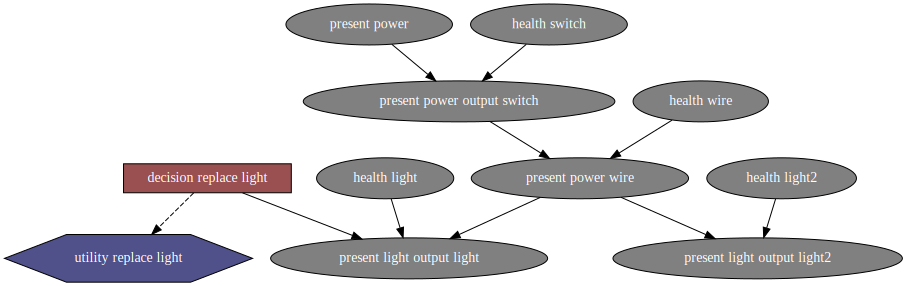

In [73]:
# create influence diagram, replace light
diagram = gum.InfluenceDiagram()
baseStructure(diagram)
baseArcs(diagram)
#addObservationObserveLight(diagram)
#addObservationObserveSwitch(diagram)
#addObservationCheckLight(diagram)
#addFlipSwitch(diagram) 
#augmentFlipSwitch(diagram)
addReplaceLight(diagram)
augmentReplaceLight(diagram)
print(diagram)
gnb.showInfluenceDiagram(diagram, size=60)

# probabilities

In [ ]:
# CL1
diag.cpt(CL1)[{"CS1":0, "HL1":0}] = [0.99, 0.01]  # CS1:on,  HL1:ok     > CL1 should be on
diag.cpt(CL1)[{"CS1":0, "HL1":1}] = [0.05, 0.95]  # CS1:on,  HL1:broken > CL1 should be off
diag.cpt(CL1)[{"CS1":1, "HL1":0}] = [0.1, 0.9]    # CS1:off, HL1:ok     > CL1 should be off
diag.cpt(CL1)[{"CS1":1, "HL1":1}] = [0.05, 0.95]  # CS1:off, HL1:broken > CL1 should be off

In [ ]:
# HL1
diag.cpt(HL1)[0] = 0.7  # most likely light is not broken
diag.cpt(HL1)[1] = 0.3  # but 30% chance light is broken

In [ ]:
# RL1T1
diag.cpt(RL1T1)[{"HL1": "ok"}]          = [0.95, 0.05, 0.0]  # HL1:ok > RL1T1 likely not done
diag.cpt(RL1T1)[{"HL1": "broken"}]      = [0.4, 0.1, 0.5]  # HL1:broken > RL1T1 likely broken

In [ ]:
# RL1T2
diag.cpt(RL1T2)[{"RL1T1": "not done"}]    = [0.95, 0.05, 0.0]   # RL1T1:not done > RL1T2 likely not done
diag.cpt(RL1T2)[{"RL1T1": "ok"}]          = [0.05, 0.90, 0.05]  # RL1T1:ok > RL1T2 likely OK
diag.cpt(RL1T2)[{"RL1T1": "broken"}]      = [0.4, 0.1, 0.5]   # RL1T1:broken > RL1T2 likely broken or not done

In [ ]:
gnb.flow.row(diag.cpt(CL1),
            diag.cpt(HL1),
            diag.cpt(RL1T1),
            diag.cpt(RT2),
            captions=[  "prior of CL1",
                        "prior of HL1",
                        "prior of RL1T1",
                        "prior of RT2"
                      ])

In [ ]:
# CS1
diag.cpt(CS1)[{"HS1":0}] = [0.95, 0.05]  # when CS1:on, HS1: healthy > CS1 should be on
diag.cpt(CS1)[{"HS1":1}] = [0.1, 0.9]  # when CS1:on, HS1: broken > CS1 likely off

In [ ]:
# HS1
diag.cpt(HS1)[0] = 0.7  # most likely light is not broken
diag.cpt(HS1)[1] = 0.3  # but 30% chance light is broken

In [ ]:
# RS1T1
diag.cpt(RS1T1)[{"HS1": "ok"}]          = [0.95, 0.05, 0.0]  # Hs1:ok > RST1 likely not done
diag.cpt(RS1T1)[{"HS1": "broken"}]      = [0.4, 0.1, 0.5]  # HS1:broken > RST1 likely broken

In [ ]:
gnb.flow.row(diag.cpt(CS1),
            diag.cpt(HS1),
            diag.cpt(RST1),
            captions=[  "prior of CS1",
                        "prior of HS1",
                        "prior of RST1"
                      ])

# utility function

In [ ]:
diag.utility("UL1T1")[{"HL1":"ok", "DL1T1": "yes"}]           = 1   # test done but not relevant
diag.utility("UL1T1")[{"HL1":"broken", "DL1T1": "yes"}]       = 3   # test done when broken, excellent
diag.utility("UL1T1")[{"HL1":"ok", "DL1T1": "no"}]            = 2   # test not done but that's ok
diag.utility("UL1T1")[{"HL1":"broken", "DL1T1": "no"}]        = 0   # test not done when broken: missed chance

In [ ]:
diag.utility("UL1T2")[{"RL1T1":"not done", "DL1T2": "yes"}]     = 1   # test done but not relevant
diag.utility("UL1T2")[{"RL1T1":"ok", "DL1T2": "yes"}]           = 0   # test done but not relevant
diag.utility("UL1T2")[{"RL1T1":"broken", "DL1T2": "yes"}]       = 3   # test done when broken, excellent
diag.utility("UL1T2")[{"RL1T1":"not done", "DL1T2": "no"}]      = 2   # test not done but not relevant
diag.utility("UL1T2")[{"RL1T1":"ok", "DL1T2": "no"}]            = 3   # test not done but that's ok
diag.utility("UL1T2")[{"RL1T1":"broken", "DL1T2": "no"}]        = 2   # test not done when broken: missed chance


In [ ]:
diag.utility("URL1")[{"RL1T2":"not done", "DRL1": "replace"}]    = 2   # test done but not relevant
diag.utility("URL1")[{"RL1T2":"not done", "DRL1": "keep"}]       = 4   # test not done but that's ok
diag.utility("URL1")[{"RL1T2":"ok"      , "DRL1": "replace"}]          = 0   # test done but not relevant
diag.utility("URL1")[{"RL1T2":"ok"      , "DRL1": "keep"}]             = 3   # test not done but that's ok
diag.utility("URL1")[{"RL1T2":"broken"  , "DRL1": "replace"}]      = 4   # test done when broken, excellent
diag.utility("URL1")[{"RL1T2":"broken"  , "DRL1": "keep"}]         = 4   # test not done when broken: missed chance

In [ ]:
gnb.flow.row(diag.utility("UL1T1"),
            diag.utility("UL1T2"),
            diag.utility("URL1"),
           
            captions=[  "utility UT1",
                        "utility UT2",
                        "utility URL1",
                      ])

In [ ]:
diag.utility("US1T1")[{"HS1":"ok"    , "DS1T1": "yes"}]       = 1   # test done but not relevant
diag.utility("US1T1")[{"HS1":"broken", "DS1T1": "yes"}]       = 3   # test done when broken, excellent
diag.utility("US1T1")[{"HS1":"ok"    , "DS1T1": "no"}]        = 2   # test not done but that's ok
diag.utility("US1T1")[{"HS1":"broken", "DS1T1": "no"}]        = 0   # test not done when broken: missed chance

In [ ]:
diag.utility("URS1")[{"RS1T1":"not done", "DRS1": "replace"}]    = 2   # test done but not relevant
diag.utility("URS1")[{"RS1T1":"not done", "DRS1": "keep"}]       = 4   # test not done but that's ok
diag.utility("URS1")[{"RS1T1":"ok"      , "DRS1": "replace"}]          = 0   # test done but not relevant
diag.utility("URS1")[{"RS1T1":"ok"      , "DRS1": "keep"}]             = 3   # test not done but that's ok
diag.utility("URS1")[{"RS1T1":"broken"  , "DRS1": "replace"}]      = 4   # test done when broken, excellent
diag.utility("URS1")[{"RS1T1":"broken"  , "DRS1": "keep"}]         = 4   # test not done when broken: missed chance

In [ ]:
gnb.flow.row(diag.utility("US1T1"),
            diag.utility("URS1"),
           
            captions=[  "utility US1T1",
                        "utility URS1"
                      ])

In [ ]:
diag.saveBIFXML("lightv5.xml")

In [6]:
import abc

class ComponentInterface(metaclass=abc.ABCMeta):
        
    @abc.abstractmethod
    def get_health(self):
        return self.health
    
    @abc.abstractmethod
    def get_input(self):
        self.input = 5
        return self.input
    
    @abc.abstractmethod
    def get_output(self):
        return self.output
    
    
class Switch(ComponentInterface):
    def get_output(self):
        a = self.input * 2
        return a
    

In [9]:
py = Switch()
print(str(py.get_output()))

TypeError: Can't instantiate abstract class Switch with abstract methods get_health, get_input

In [ ]:
class FormalParserInterface(metaclass=abc.ABCMeta):
    @classmethod
    def __subclasshook__(cls, subclass):
        return (hasattr(subclass, 'load_data_source') and 
                callable(subclass.load_data_source) and 
                hasattr(subclass, 'extract_text') and 
                callable(subclass.extract_text) or 
                NotImplemented)

    @abc.abstractmethod
    def load_data_source(self, path: str, file_name: str):
        """Load in the data set"""
        raise NotImplementedError

    @abc.abstractmethod
    def extract_text(self, full_file_path: str):
        """Extract text from the data set"""
        raise NotImplementedError

class PdfParserNew(FormalParserInterface):
    """Extract text from a PDF."""
    def load_data_source(self, path: str, file_name: str) -> str:
        """Overrides FormalParserInterface.load_data_source()"""
        pass

    def extract_text(self, full_file_path: str) -> dict:
        """Overrides FormalParserInterface.extract_text()"""
        pass